In [3]:
BASE_PATH = "/content/drive/MyDrive/nlp_7th_sem/lab5"

CORPUS_FILE = f"{BASE_PATH}/validation_corpus.csv"
QUERIES_FILE = f"{BASE_PATH}/validation_queries.csv"
TRIPLET_DATASET_NAME = f"{BASE_PATH}/train_triplet.csv"

In [1]:
import pandas as pd
from sentence_transformers import InputExample
from torch.utils.data import DataLoader

def load_validation_data(corpus_path, queries_path):
    print("Loading Validation Corpus and Queries...")

    df_corpus = pd.read_csv(corpus_path, sep="|")

    df_corpus['display_name'] = df_corpus['display name'].fillna('')
    df_corpus['description'] = df_corpus['description'].fillna('')

    df_corpus['combined_text'] = (
        df_corpus['display_name'] + " " + df_corpus['description']
    )

    print(f"Corpus loaded: {len(df_corpus)} documents.")

    df_queries = pd.read_csv(
        queries_path,
        sep="|",
        converters={'expected_results': pd.eval}
    )
    print(f"Queries loaded: {len(df_queries)} queries.")

    return df_corpus, df_queries


def load_training_data(dataset_path):
    print(f"Loading Training Data...")

    df_train = pd.read_csv(dataset_path)

    train_examples = []
    for _, row in df_train.iterrows():
        train_examples.append(
            InputExample(
                texts=[row['anchor'], row['positive'], row['negative']]
            )
        )

    print(f"Training examples prepared: {len(train_examples)}")

    return DataLoader(train_examples, shuffle=True, batch_size=64)


In [4]:
df_corpus, df_validation_queries = load_validation_data(CORPUS_FILE, QUERIES_FILE)

train_dataloader = load_training_data(TRIPLET_DATASET_NAME)

Loading Validation Corpus and Queries...
Corpus loaded: 5000 documents.
Queries loaded: 55 queries.
Loading Training Data...
Training examples prepared: 10000


In [5]:
from sentence_transformers import SentenceTransformer, models

word_embedding_model = models.Transformer('bert-base-uncased', max_seq_length=256)

pooling_model = models.Pooling(
    word_embedding_model.get_word_embedding_dimension(),
    pooling_mode='mean'
)

model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [6]:
import numpy as np

tokenizer = model._first_module().tokenizer


texts = df_corpus["combined_text"].tolist()
token_lengths = [len(tokenizer.tokenize(text)) for text in texts]

max_length = np.max(token_lengths)
avg_length = np.mean(token_lengths)
p95_length = np.percentile(token_lengths, 95)

print(f"Max token length found: {max_length}")
print(f"Average token length: {avg_length:.2f}")
print(f"95th percentile length: {p95_length:.0f}")

Token indices sequence length is longer than the specified maximum sequence length for this model (286 > 256). Running this sequence through the model will result in indexing errors


Max token length found: 14179
Average token length: 150.23
95th percentile length: 252


In [7]:
from sentence_transformers import losses

import os
os.environ['WANDB_DISABLED'] = 'true'

num_epochs = 5
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1)
train_loss = losses.TripletLoss(model=model, distance_metric=losses.TripletDistanceMetric.COSINE, triplet_margin=0.3)

print(f"Starting training for {num_epochs} epochs...")
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=num_epochs,
    warmup_steps=warmup_steps,
    output_path=f'{BASE_PATH}/sentence_transformer_model',
    show_progress_bar=True,

)
print("Training complete. Model saved.")

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Starting training for 5 epochs...


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss
500,0.024300


Training complete. Model saved.


In [8]:
from sklearn.metrics.pairwise import cosine_similarity


print("\nGenerating corpus embeddings...")
corpus_embeddings = model.encode(df_corpus["combined_text"].tolist(), show_progress_bar=True, convert_to_tensor=True)

print("Generating query embeddings...")
query_embeddings = model.encode(df_validation_queries['queries'].tolist(), show_progress_bar=True, convert_to_tensor=True)

print("Calculating cosine similarities...")
cos_scores = cosine_similarity(query_embeddings.cpu().numpy(), corpus_embeddings.cpu().numpy())


Generating corpus embeddings...


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Generating query embeddings...


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Calculating cosine similarities...


In [35]:
import numpy as np
from tqdm.autonotebook import tqdm

TOP_K = 50
all_results = []
for i in tqdm(range(len(df_validation_queries['queries'])), desc="Retrieving top results"):
    top_indices = np.argsort(cos_scores[i])[-TOP_K:][::-1]
    all_results.append(top_indices.tolist())

df_validation_queries['retrieved_results'] = all_results

Retrieving top results:   0%|          | 0/55 [00:00<?, ?it/s]

In [38]:
def calculate_metrics(df, k=5):
    precision_list, recall_list, f_score_list, avg_precision_list = [], [], [], []

    for _, row in df.iterrows():
        expected = set(row['expected_results'])
        retrieved = row['retrieved_results'][:k]

        relevant_retrieved = len(expected.intersection(retrieved))

        # Precision@k: (Relevant Retrieved) / k
        P_k = relevant_retrieved / k

        # Recall@k: (Relevant Retrieved) / (Total Relevant)
        R_k = relevant_retrieved / len(expected) if len(expected) > 0 else 0

        # F-score@:
        F_k = (2 * P_k * R_k) / (P_k + R_k) if (P_k + R_k) > 0 else 0

        precision_list.append(P_k)
        recall_list.append(R_k)
        f_score_list.append(F_k)

        # Average Precision (AP) for MAP calculation (using all retrieved results)
        ap = 0
        hits = 0
        for rank, doc_index in enumerate(row['retrieved_results']):
            if doc_index in expected:
                hits += 1
                ap += hits / (rank + 1)

        AP = ap / len(expected) if len(expected) > 0 else 0
        avg_precision_list.append(AP)


    return {
        f'Precision@{k}': np.mean(precision_list),
        f'Recall@{k}': np.mean(recall_list),
        f'F-score@{k}': np.mean(f_score_list),
        'MAP': np.mean(avg_precision_list)
    }

In [41]:
metrics = calculate_metrics(df_validation_queries, k=5)
print("\n--- Training Results (Post-Training) ---")
print(metrics)


--- Training Results (Post-Training) ---
{'Precision@5': np.float64(0.06909090909090909), 'Recall@5': np.float64(0.034545454545454546), 'F-score@5': np.float64(0.04606060606060606), 'MAP': np.float64(0.03865328386845639)}


In [27]:
import umap
import matplotlib.pyplot as plt
import random
import numpy as np
from tqdm.autonotebook import tqdm
import torch

def create_umap_visualization(corpus_embeddings, query_embeddings, df_corpus, df_validation_queries):

    # Ensure embeddings are NumPy arrays for UMAP
    if isinstance(corpus_embeddings, torch.Tensor):
        corpus_embeddings = corpus_embeddings.cpu().numpy()
    if isinstance(query_embeddings, torch.Tensor):
        query_embeddings = query_embeddings.cpu().numpy()

    # --- 1. UMAP Dimensionality Reduction ---
    print("\nStarting UMAP dimensionality reduction (768D -> 2D)...")

    # Combine all embeddings for a consistent UMAP projection
    all_embeddings = np.concatenate([corpus_embeddings, query_embeddings], axis=0)

    reducer = umap.UMAP(
        n_neighbors=15,
        min_dist=0.1,
        n_components=2,
        random_state=42,
        metric='cosine'
    )

    # Fit and transform the data
    projected_embeddings = reducer.fit_transform(all_embeddings)

    # Separate the projected data back into corpus and queries
    corpus_2d = projected_embeddings[:len(corpus_embeddings)]
    queries_2d = projected_embeddings[len(corpus_embeddings):]

    print("UMAP reduction complete.")

    # --- 2. Select a Random Query for Plotting ---
    # We choose a query that has at least one expected result to make the plot meaningful.
    valid_queries = df_validation_queries[df_validation_queries['expected_results'].apply(len) > 0]

    if valid_queries.empty:
        print("Error: No queries with expected results found for visualization.")
        return

    # Randomly pick one query index
    query_index = random.choice(valid_queries.index)
    query_text = df_validation_queries.loc[query_index, 'queries']

    retrieved_indices = df_validation_queries.loc[query_index, 'retrieved_results'][:10] # Top 10
    expected_indices = df_validation_queries.loc[query_index, 'expected_results']

    # --- 3. Prepare Data for Plotting ---

    # a) Full Corpus (Gray dots)
    plt.scatter(corpus_2d[:, 0], corpus_2d[:, 1],
                c='lightgray', s=10, label='Corpus (All Documents)')

    # b) Query Point (Star)
    plt.scatter(queries_2d[query_index, 0], queries_2d[query_index, 1],
                c='red', marker='*', s=200, label='Query Point', edgecolors='black')

    # c) Expected (Correct) Results (Green circles)
    # Filter for documents that are in the corpus and were expected
    expected_mask = np.zeros(len(df_corpus), dtype=bool)
    expected_mask[list(expected_indices)] = True

    plt.scatter(corpus_2d[expected_mask, 0], corpus_2d[expected_mask, 1],
                c='green', marker='o', s=80, label='Expected Correct Results', edgecolors='black')

    # d) Retrieved (Top 10) Results (Blue squares)
    # The assignment asks to highlight the Top 10 retrieved documents.
    retrieved_mask = np.zeros(len(df_corpus), dtype=bool)
    retrieved_mask[retrieved_indices] = True

    # Plot retrieved results, checking for overlap with expected results
    retrieved_and_correct = set(retrieved_indices).intersection(set(expected_indices))
    retrieved_only = set(retrieved_indices) - retrieved_and_correct

    # Plot retrieved results that are NOT correct (False Positives)
    if retrieved_only:
        retrieved_only_mask = np.zeros(len(df_corpus), dtype=bool)
        retrieved_only_mask[list(retrieved_only)] = True
        plt.scatter(corpus_2d[retrieved_only_mask, 0], corpus_2d[retrieved_only_mask, 1],
                    c='blue', marker='s', s=80, label='Retrieved Results (False Positives)', edgecolors='black')

    # Plot results that are Retrieved AND Correct (True Positives)
    # These will often overlap with the green dots, but we plot them last to ensure visibility
    if retrieved_and_correct:
        retrieved_correct_mask = np.zeros(len(df_corpus), dtype=bool)
        retrieved_correct_mask[list(retrieved_and_correct)] = True
        plt.scatter(corpus_2d[retrieved_correct_mask, 0], corpus_2d[retrieved_correct_mask, 1],
                    c='orange', marker='D', s=100, label='Retrieved & Correct (True Positives)', edgecolors='black', zorder=5)


    # --- 4. Plot Customization and Labels ---

    plt.title(f'UMAP Projection: Search Results for Query: "{query_text[:50]}..."', fontsize=14)
    plt.xlabel('UMAP Component 1')
    plt.ylabel('UMAP Component 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

    # Print the result breakdown for console
    print(f"\n--- Query Visualization Summary ---")
    print(f"Query: {query_text}")
    print(f"Total Expected Results: {len(expected_indices)}")
    print(f"Top 10 Retrieved Results: {len(retrieved_indices)}")
    print(f"Correctly Retrieved (True Positives): {len(retrieved_and_correct)}")
    print(f"False Positives (Retrieved but Incorrect): {len(retrieved_only)}")



Starting UMAP dimensionality reduction (768D -> 2D)...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP reduction complete.


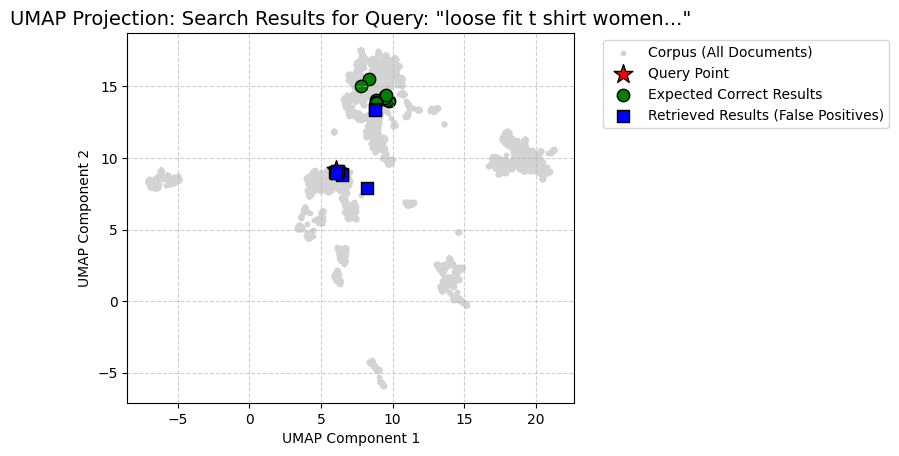


--- Query Visualization Summary ---
Query: loose fit t shirt women
Total Expected Results: 10
Top 10 Retrieved Results: 10
Correctly Retrieved (True Positives): 0
False Positives (Retrieved but Incorrect): 10


In [42]:
create_umap_visualization(corpus_embeddings, query_embeddings, df_corpus, df_validation_queries)